In [1]:
import json

with open("./ids_forwards_posts_10k.json") as f:
    data = json.load(f)

In [2]:
threshold = 5

edges = [(d["from"], d["to"]) for d in data if len(d["posts"]) > threshold]
weights = [len(d["posts"]) for d in data if len(d["posts"]) > threshold]

In [3]:
nodes_count = len(set(e[0] for e in edges).union(set(e[1] for e in edges)))
nodes_count

1725

In [4]:
print(f"Posts count: {sum(weights)}")
print(f"Number of edges: {len(edges)}")
print(f"Number of nodes: {nodes_count}")
print(f"Average posts: {sum(weights) / len(weights):.1f}")
print(f"Max posts: {max(weights)}")
print(f"Min posts: {min(weights)}")

Posts count: 82742
Number of edges: 1675
Number of nodes: 1725
Average posts: 49.4
Max posts: 10826
Min posts: 6


In [5]:
def reduce_small_components(g, num_components):
    components = g.clusters(mode="weak")  # Use "strong" for directed graphs

    # Filter components with node count >= 3
    large_components = [comp for comp in components if len(comp) > num_components]

    # Combine the nodes from the remaining components
    nodes_to_keep = [node for comp in large_components for node in comp]

    # Create a subgraph with the filtered nodes
    reduced_graph = g.subgraph(nodes_to_keep)
    return reduced_graph

/var/folders/d3/tlp4l7t96hs7g1hs5kw3d44r0000gn/T/ipykernel_26424/1331974653.py:2: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  components = g.clusters(mode="weak")  # Use "strong" for directed graphs


952


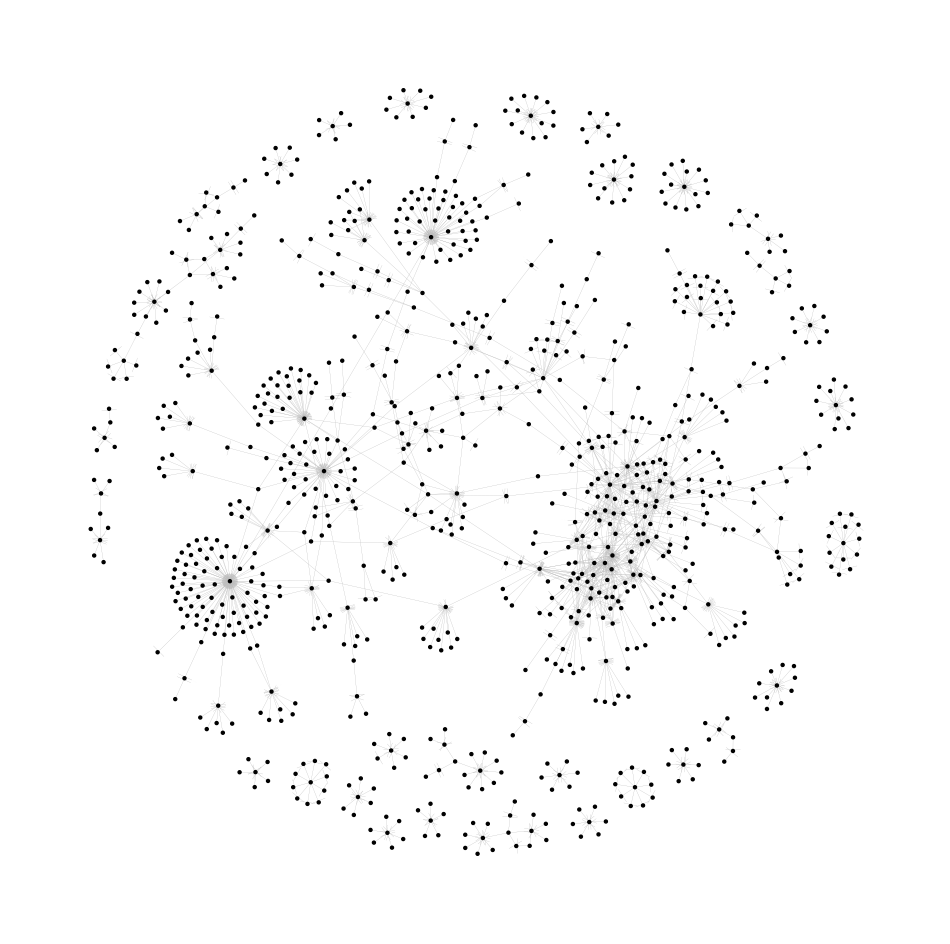

In [6]:
import igraph as ig
import matplotlib.pyplot as plt

# Create a graph with the edges
g = ig.Graph(n=nodes_count, edges=edges, directed=True)
# Assign weights to edges
g.es['weight'] = weights

isolated_nodes = [v.index for v in g.vs if v.degree() == 0]
# Remove isolated nodes (if any)
g.delete_vertices(isolated_nodes)

g = reduce_small_components(g, 5)

print(g.vcount())

# # Assign labels to nodes (optional)
# g.vs['label'] = [f"Node {i}" for i in range(g.vcount())]

# Define the layout using Fruchterman-Reingold
inverse_weights = [w for w in g.es['weight']]
layout = g.layout_sugiyama(weights=inverse_weights)

# Plot the graph
fig, ax = plt.subplots(figsize=(12, 12))
ig.plot(
    g,
    target=ax,
    vertex_size=3,
    edge_arrow_size=0.1,  # Size of arrows to show edge direction
    vertex_color="black",
    vertex_border_width=0,  # Node color
    edge_color="gray",  # Edge color
    edge_width=0.1,
)
plt.show()

In [198]:
g.es[0].tuple

(353, 135)

In [14]:
import igraph as ig
import plotly.graph_objects as go

# # Define edges and weights for the graph
# edges = [(0, 1), (1, 2), (2, 3), (3, 0), (0, 2), (1, 3)]
# weights = [1.0, 2.5, 3.0, 4.5, 1.5, 2.0]  # Weights for edges

# Create the graph
g = ig.Graph(edges=edges, directed=True)
g.es['weight'] = weights

# Remove isolated nodes (nodes with degree 0)
isolated_nodes = [v.index for v in g.vs if v.degree() == 0]
g.delete_vertices(isolated_nodes)

# Generate a 3D Kamada-Kawai layout and scale it
layout = g.layout_kamada_kawai(dim=3, weights=[w for w in weights])  # Use inverse weights
scaled_layout = [(x, y, z) for x, y, z in layout.coords]  # Scale the layout

# Extract 3D coordinates for plotting
x_coords, y_coords, z_coords = zip(*scaled_layout)

# Create edge traces for the 3D plot
edge_x = []
edge_y = []
edge_z = []
edge_text = []  # To store the weights of edges for hover info

for edge in g.es:
    edge = edge.tuple
    edge_x += [x_coords[edge[0]], x_coords[edge[1]], None]
    edge_y += [y_coords[edge[0]], y_coords[edge[1]], None]
    edge_z += [z_coords[edge[0]], z_coords[edge[1]], None]
    # Add edge weight as hover text

edge_trace = go.Scatter3d(
    x=edge_x,
    y=edge_y,
    z=edge_z,
    mode='lines',
    line=dict(width=0.5, color='gray'),
    hoverinfo='text',
    text=edge_text  # Display edge weight on hover
)

# Create node traces for the 3D plot
node_trace = go.Scatter3d(
    x=x_coords,
    y=y_coords,
    z=z_coords,
    mode='markers+text',
    marker=dict(size=2, color='lightblue', opacity=0.9),  # Node customization
    # text=[f"Node {i}" for i in range(len(x_coords))],
    textposition="top center",
    hoverinfo='text'
)

# Combine the edge and node traces for the final figure
fig = go.Figure(data=[edge_trace, node_trace])

# Configure layout for the 3D plot
fig.update_layout(
    title="Interactive 3D Graph (No Isolated Nodes)",
    scene=dict(
        xaxis=dict(title='X-axis'),
        yaxis=dict(title='Y-axis'),
        zaxis=dict(title='Z-axis'),
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    width=1200,
    height=800,
)

# Show the interactive plot
fig.show()

KeyboardInterrupt: 